In [1]:
using Distributions
using Plots

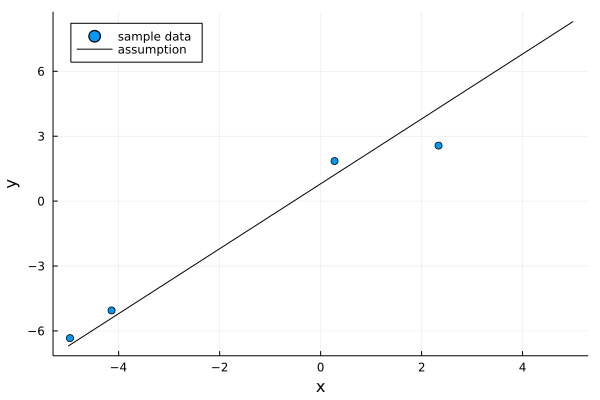

In [17]:
# 真のパラメータ
true_w1 = 1.5
true_w2 = 0.8

# サンプルデータ
N = 4
x_data = rand(Uniform(-5, 5), N)
y_data = true_w1 .* x_data .+ true_w2 .+ rand(Normal(0, 1), N)

# データの描画
xs = -5:5
ys = true_w1 .* xs .+ true_w2
scatter(x_data, y_data, xlabel="x", ylabel="y", label="sample data", legend=:topleft)
plot!(xs, ys, color="black", label="assumption")